<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_1/images/SN_web_lightmode.png" width="300"> 
</center>


<h1>Refine the Baseline Regression Models</h1>

Estimated time needed: **120** minutes


## Lab Overview:

Now you have built a baseline regression model with some relatively good RMSE and R-squared reported values. However, we could still improve it by using methods like adding polynomial and interaction terms, regularization, and so on.

In this lab, you will be asked to continue using `tidymodels` to improve the performance of baseline model:

- **TASK: Add polynomial terms**
- **TASK: Add interactions terms**
- **TASK: Add regularizations terms**
- **TASK: Experiment to search for improved models**


Let's start!


The tidyverse and the tidymodels packages can be used to produce high quality statistical and machine learning models. The Tidyverse library is a useful tool that provides various tools for data visualization, data manipulation, and read various datasets into a data frame; our Jupyter notebook platforms have a built-in Tidymodels, Tidyverse and rlang libraries, so we do not need to install these packages prior to loading library. However, if you decide to run this lab on your RStudio Desktop locally on your machine, you can remove the commented lines of code to install these packages before loading.


In [ ]:
# Uncomment to install packages if running locally
# install.packages("tidyverse")
# install.packages("tidymodels")

In [1]:
library("tidymodels")
library("tidyverse")
library("stringr")

── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.6      ✔ recipes   0.1.12
✔ dials     0.0.6      ✔ rsample   0.0.5 
✔ dplyr     0.8.5      ✔ tibble    3.0.1 
✔ ggplot2   3.3.0      ✔ tune      0.1.0 
✔ infer     0.5.1      ✔ workflows 0.1.1 
✔ parsnip   0.1.0      ✔ yardstick 0.0.6 
✔ purrr     0.3.4      
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()  masks scales::discard()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks dials::margin()
✖ recipes::step()   masks stats::step()
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ stringr 1.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter

The processed Seoul bike sharing dataset `seoul_bike_sharing_converted_normalized.csv`,  includes the converted indicator variables, and the numerical variables have been normalized. 
Let's read it as a dataframe first:


In [2]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Parsed with column specification:
cols(
  .default = col_double(),
  DATE = col_character(),
  FUNCTIONING_DAY = col_character()
)
See spec(...) for full column specifications.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.


In [3]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.


In [4]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>% 
  set_mode("regression")

Split the data into training and testing datasets.


In [5]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

Now we are ready to refine the previous baseline regression model.


# TASK: Add polynomial terms


Linear regression models are the most suitable models to capture the linear correlations among variables. However, in real world data, many relationships may be non-linear.


For example, the correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look like linear:


`geom_smooth()` using formula 'y ~ x'


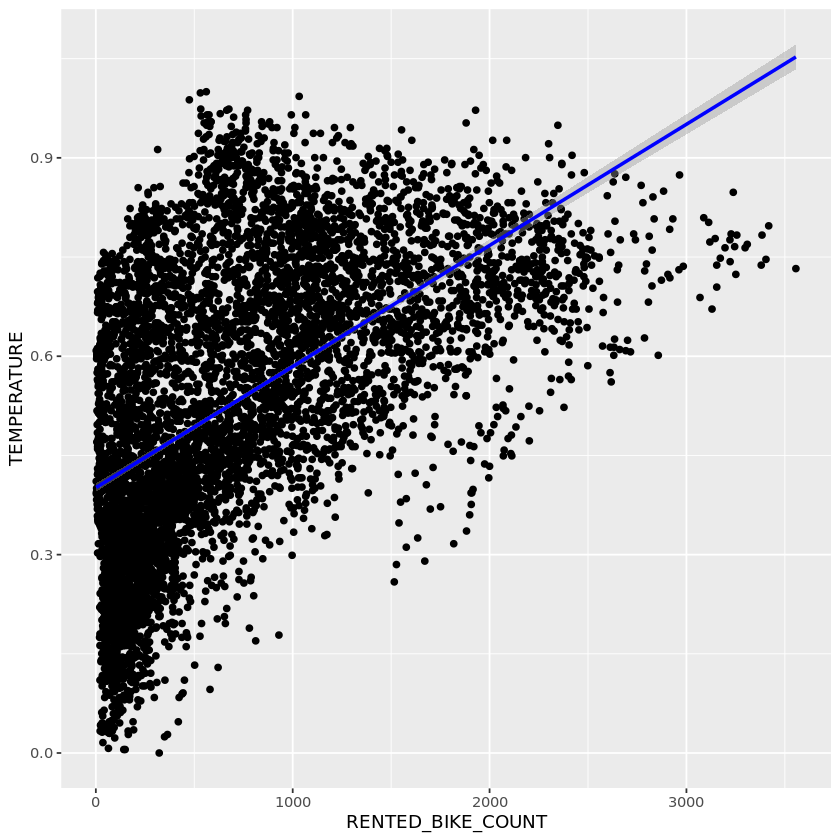

In [6]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() +
    geom_smooth(method = "lm", color = "BLUE")

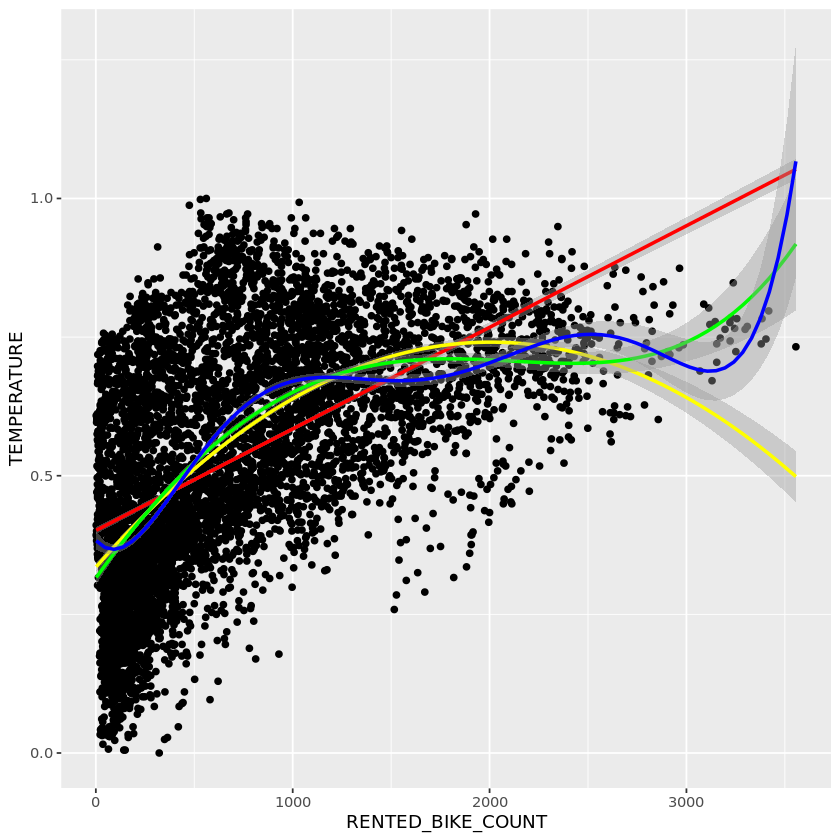

In [7]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() + 
    geom_smooth(method = "lm", formula = y ~ x, color="red") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

OK, let's add some higher order polynomials of important variables to the regression models


_TODO:_ Fit a linear regression model `lm_poly` with higher order polynomial terms on the important variables (larger coefficients) found in the baseline model


In [8]:
# Fit a linear model with higher order polynomial on some important variables 
# #HINT: Use ploy function to build polynomial terms, lm_poly <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) .....
lm_poly <- linear_reg() %>%
 set_engine("lm") %>%
 set_mode("regression")

lm_poly <- lm_poly %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) + poly(DEW_POINT_TEMPERATURE, 4), data = train_data)

In [9]:
# Print model summary
summary(lm_poly$fit)


Call:
stats::lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1542.77  -201.29     3.33   186.59  1485.27 

Coefficients: (6 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        203.45      79.80   2.550 0.010809 *  
TEMPERATURE                       1877.51     460.02   4.081 4.53e-05 ***
HUMIDITY                          -483.40     219.79  -2.199 0.027888 *  
WIND_SPEED                           4.00      34.98   0.114 0.908953    
VISIBILITY                         -41.57      18.22  -2.282 0.022548 *  
DEW_POINT_TEMPERATURE             -666.65     505.16  -1.320 0.186984    
SOLAR_RADIATION                    -13.27      38.54  -0.344 0.730700    
RAINFALL                         -1171.14     134.76  -8.690  < 2e-16 ***
SNOWFALL                           -99.67      90.25  -1.104 0.269516    
`0`                                -71.79      29.0

_TODO:_ Make predictions on test dataset using the `lm_poly` models


In [10]:
# Use predict() function to generate test results for `lm_poly`
lm_ploy_train_results <- lm_poly %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)
head(lm_ploy_train_results)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”

.pred,truth
<dbl>,<dbl>
103.492035,254
-5.106321,204
-192.286368,107
-246.013611,100
216.829328,460
627.999728,930


Another minor improvement we could do here is to convert all negative prediction results to zero, because we can not have negative rented bike counts


In [11]:
# e.g., test_results[test_results<0] <- 0
# Use predict() function to generate test results for `lm_poly` and set negative predictions to zero
lm_poly_train_results <- lm_poly %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT,
         .pred = pmax(.pred, 0))  # Convert negative predictions to zero

# Display the first few rows of the result
head(lm_poly_train_results)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”

.pred,truth
<dbl>,<dbl>
103.4920,254
0.0000,204
0.0000,107
0.0000,100
216.8293,460
627.9997,930


Now, calculate R-squared and RMSE for the test results generated by `lm_ploy` model


In [12]:
# Calculate R-squared and RMSE from the test results
rsq_lm_poly <- rsq(lm_poly_train_results,
  truth = truth,
  estimate = .pred
)

rmse_lm_poly <- rmse(lm_poly_train_results,
  truth = truth,
  estimate = .pred
)

rsq_lm_poly
rmse_lm_poly

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7556552


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,320.2715


If you include all variables, and additionally include some of the more important ones as higher order poly terms, then you should notice improved  `R-squared` and `RMSE` values.


# TASK: Add interaction terms


In real-world scenarios, in addition to non-linear relationships between response variables and predictor variables, you may also encounter relationships among variables called `interaction effects`.

For example, the effect of predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables such as `HUMIDITY`, `RAINFALL`, or both (they `interact`) and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, we could add some interaction terms such as `RAINFALL*HUMIDITY` to the regression model, similar to what we did with polynominal terms. In this task, you will explore and conduct some experiments to search for interaction terms which will improve the model performance.


_TODO:_ Try adding some interaction terms to the previous polynomial models.


In [13]:
# Add interaction terms to the poly regression built in previous step
# HINT: You could use `*` operator to create interaction terms such as HUMIDITY*TEMPERATURE and make the formula look like:
# RENTED_BIKE_COUNT ~ RAINFALL*HUMIDITY ...
lm_poly <- linear_reg() %>%
 set_engine("lm") %>%
 set_mode("regression")

lm_poly <- lm_poly %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) + poly(DEW_POINT_TEMPERATURE, 4) + RAINFALL * HUMIDITY + HUMIDITY * TEMPERATURE 
                            + AUTUMN * HOLIDAY + AUTUMN * `18` + AUTUMN * `19` + AUTUMN * `8`, data = train_data)

# consider also negative  values -> set to zero!
lm_poly_train <- lm_poly %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT,
                 .pred = pmax(.pred, 0)) 

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”

In [14]:
# Print model summary
head(lm_poly_train)
summary(lm_poly$fit)

.pred,truth
<dbl>,<dbl>
96.69578,254
0.00000,204
0.00000,107
0.00000,100
212.41033,460
544.55493,930



Call:
stats::lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1441.54  -196.55     6.25   183.17  1529.00 

Coefficients: (6 not defined because of singularities)
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -1817.302    229.683  -7.912 2.94e-15 ***
TEMPERATURE                       6105.808    645.729   9.456  < 2e-16 ***
HUMIDITY                          3484.008    478.476   7.281 3.68e-13 ***
WIND_SPEED                          -1.591     34.502  -0.046 0.963227    
VISIBILITY                         -30.808     17.987  -1.713 0.086791 .  
DEW_POINT_TEMPERATURE             -813.037    498.598  -1.631 0.103012    
SOLAR_RADIATION                    -23.542     38.112  -0.618 0.536780    
RAINFALL                        -27770.250   5018.697  -5.533 3.26e-08 ***
SNOWFALL                          -298.482     91.298  -3.269 0.001083 ** 
`0`                                -72.62

In [15]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
rsq_lm_poly <- rsq(lm_poly_train,
  truth = truth,
  estimate = .pred
)

rmse_lm_poly <- rmse(lm_poly_train,
  truth = truth,
  estimate = .pred
)

rsq_lm_poly
rmse_lm_poly

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7614983


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,316.1131


# TASK: Add regularization


In previous tasks, you were asked to add polynominal and interaction terms to the model, aiming to capture nonlinearity and interaction effects between the predictor variables. Hopefully, your updated models have better R-squared and RMSE values.

However, adding these terms makes your model more complicated, more difficult to explain, and more likely to suffer from overfitting. To overcome these issues, one solution is to add regularization terms to your models.


When building the baseline model, we used the basic `lm` engine. In this task, you will use a more advanced and generalized `glmnet` engine. It provides a generalized linear model with Lasso, Ridge, and Elastic Net regularizations.

In general, using `glmnet` can enhance your models in the following ways:
- Address overfitting issues by shrinking the coefficients
- Address predictor variable colinearity by selecting only one variable from each group of colinear variables (by shrinking their coefficients to zero)
- Make your models more interpretable due to simplification (fewer variables in the outcome models)


Now, let's switch our regression engine to `glmnet`


_TODO:_ Define a linear regression model specification `glmnet_spec` using `glmnet` engine


In [29]:
# HINT: Use linear_reg() function with two parameters: penalty and mixture
# - penalty controls the intensity of model regularization
# - mixture controls the tradeoff between L1 and L2 regularizations
# You could manually try different parameter combinations or use grid search to find optimal combinations

Fit a glmnet model called  `lm_glmnet` using the `fit()` function. For the formula part, keep the polynominal and interaction terms you used in the previous task.


In [16]:
install.packages('glmnet')

Warning message:
“package ‘glmnet’ is not available (for R version 3.5.1)”

In [17]:
library('glmnet')

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-18



In [22]:
# Define the linear regression model specification with glmnet
# -> two parameters: penalty and mixture
# Define the recipe
reg_recipe <- recipe(RENTED_BIKE_COUNT ~ ., data = train_data) %>%
  step_normalize(all_predictors())

glmnet_spec <- linear_reg(penalty = tune(), mixture = 1) %>%
set_engine("glmnet")

lasso_wf <- workflow() %>%
add_recipe(reg_recipe)

flight_cvfolds <- vfold_cv(train_data)

lambda_grid <- grid_regular(levels = 50,
penalty(range = c(-3, 0.3)))

lasso_grid <- tune_grid(
lasso_wf %>% add_model(glmnet_spec),
resamples = flight_cvfolds,
grid = lambda_grid)

In [23]:
# Report rsq and rmse of the `lm_glmnet` model
# Access the best model based on RMSE
results_grid <- show_best(lasso_grid, metric = "rmse")
rmse_train <- results_grid[1,4]
rmse_train

best_params <- select_best(lasso_grid, "rmse")

# Workflow with the best parameters
final_wf <- finalize_workflow(
  lasso_wf %>% add_model(glmnet_spec),
  best_params
)

# Final model lm_glmnet based on the train data
lm_glmnet <- fit(final_wf, data = train_data)

# Step 1: Making predictions on the training data with the final model
train_predictions <- predict(lm_glmnet, new_data = train_data) %>%
  bind_cols(train_data)

# Step 2: Calculate  RMSE and RSQ
metrics_train <- train_predictions %>%
  metrics(truth = RENTED_BIKE_COUNT, estimate = .pred)

# Step 3: Report rsq and rmse of the `lm_glmnet` model
metrics_train

mean
<dbl>
376.513


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,374.5920898
rsq,standard,0.6624119
mae,standard,281.0005219


# TASK: Experiment to search for improved models


Now you understand some of the methods that you can use to try to improve your models.


_TODO:_ Experiment by building and testing at least five different models. For each of your experiments, include polynomial terms, interaction terms, and one of the three regularizations we introduced.


In [24]:
# Build at least five different models using polynomial terms, interaction terms, and regularizations.

# ********************************************************************************************************
# Model 1 - Top cor variables, polynomial top variable, interaction term & L2 regulaizations
# ********************************************************************************************************
model_01 <- linear_reg(penalty = 0.02, mixture = 1) %>%
  set_engine("glmnet")

model_01_fit <- model_01 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + DEW_POINT_TEMPERATURE 
                            + SOLAR_RADIATION + SUMMER * `18` + HUMIDITY, data = train_data)

model_01_train_results <- model_01_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model_01$.pred <- replace(model_01_train_results$.pred, model_01_train_results$.pred < 0, 0)

rsq_model_01 <- rsq(model_01_train_results,
  truth = truth,
  estimate = .pred
)

rmse_model_01 <- rmse(model_01_train_results,
  truth = truth,
  estimate = .pred
)
# Save their rmse and rsq values
print("Model 01")
rsq_model_01
rmse_model_01

# ********************************************************************************************************
# Model 2 - Top cor variables, 2 polynomial top variable, interaction term & elastic regularization
# ********************************************************************************************************
model_02 <- linear_reg(penalty = 0.02, mixture = 0.2) %>%
  set_engine("glmnet")

model_02_fit <- model_02 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) 
                            + SOLAR_RADIATION + SUMMER * `18` + TEMPERATURE * HUMIDITY, data = train_data)

model_02_results <- model_02_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model_02$.pred <- replace(model_02_results$.pred, model_02_results$.pred < 0, 0)

rsq_model_02 <- rsq(model_02_results,
  truth = truth,
  estimate = .pred
)

rmse_model_02 <- rmse(model_02_results,
  truth = truth,
  estimate = .pred
)
# Save their rmse and rsq values
print("Model 02")
rsq_model_02
rmse_model_02

# ********************************************************************************************************
# Model 3 - Top cor variables,4 polynomial top variable, interaction term & elastic regularization
# ********************************************************************************************************
model_03 <- linear_reg(penalty = 0.0015, mixture = 0.2) %>%
  set_engine("glmnet")
model_03_fit <- model_03 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) 
                            + poly(SOLAR_RADIATION, 6) + SUMMER * `18` + TEMPERATURE * HUMIDITY 
                            + poly(HUMIDITY, 6), data = train_data)

model_03_results <- model_03_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model_03$.pred <- replace(model_03_results$.pred, model_03_results$.pred < 0, 0)

rsq_model_03 <- rsq(model_03_results,
  truth = truth,
  estimate = .pred
)

rmse_model_03 <- rmse(model_03_results,
  truth = truth,
  estimate = .pred
)

# Save their rmse and rsq values
print("Model 03")
rsq_model_03
rmse_model_03

# ********************************************************************************************************
# Model 4 - Top cor variables,5 polynomial top variable, interaction term & elastic regularization
# ********************************************************************************************************
model_04 <- linear_reg(penalty = 0.0015, mixture = 0.2) %>%
  set_engine("glmnet")

model_04_fit <- model_04 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) + poly(SOLAR_RADIATION, 6) 
                            + poly(VISIBILITY, 6) + SUMMER * `18` + TEMPERATURE * HUMIDITY + poly(HUMIDITY, 6) + RAINFALL * TEMPERATURE + SNOWFALL * TEMPERATURE 
                            + RAINFALL * HUMIDITY + SNOWFALL * HUMIDITY, data = train_data)

model_04_results <- model_04_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model_04_results$.pred <- replace(model_04_results$.pred, model_04_results$.pred < 0, 0)

rsq_model_04 <- rsq(model_04_results,
  truth = truth,
  estimate = .pred
)

rmse_model_04 <- rmse(model_04_results,
  truth = truth,
  estimate = .pred
)

# Save their rmse and rsq values
print("Model 04")
rsq_model_04
rmse_model_04

# ********************************************************************************************************
# Model 5 - Top cor variables, 1 polynomial top variable, interaction term & elastic regularization
# ********************************************************************************************************
model_05 <- linear_reg(penalty = 0.0015, mixture = 0.2) %>%
  set_engine("glmnet")

model_05_fit <- model_05 %>%
  fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6), data = train_data)

model_05_results <- model_05_fit %>%
  predict(new_data = train_data) %>%
  bind_cols(train_data) %>%
  mutate(truth = RENTED_BIKE_COUNT)

model_05_results <- model_05_results %>%
  mutate(.pred = replace(.pred, .pred < 0, 0))

rsq_model_05 <- rsq(model_05_results, truth = truth, estimate = .pred)
rmse_model_05 <- rmse(model_05_results, truth = truth, estimate = .pred)

# Print the results
print("Model 05")
rsq_model_05
rmse_model_05

[1] "Model 01"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7137937


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,344.91


[1] "Model 02"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7392157


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,329.24


[1] "Model 03"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7674439


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,310.9102


[1] "Model 04"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7817489


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,302.1648


[1] "Model 05"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.3380032


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,524.559


In [25]:
# Report the best performed model in terms of rmse and rsq
# Model 01 - 05 vectors of rsq and rmse 
rsq_values <- c(0.7138, 0.7392, 0.7674, 0.7817, 0.3880)
rmse_values <- c(344.91, 329.24, 310.91, 302.16, 524.56)

# Normalize R-squared
min_rsq <- min(rsq_values)
max_rsq <- max(rsq_values)
normalized_rsq <- (rsq_values - min_rsq) / (max_rsq - min_rsq)

# Normalize RMSE (inverted)
min_rmse <- min(rmse_values)
max_rmse <- max(rmse_values)
normalized_rmse <- (max_rmse - rmse_values) / (max_rmse - min_rmse)

# Calculate final scores (weighted equally)
final_scores <- 0.5 * normalized_rsq + 0.5 * normalized_rmse

# Find the best model based on the highest final score
best_model_index <- which.max(final_scores)
best_model_index  # This gives you the index of the best model
best_model_score <- final_scores[best_model_index]

# Output the results including rsq and rmse
print("RESULT")
cat("Best model is Model", best_model_index, "\n")
cat("RMSE:", rmse_values[best_model_index], "\n")
cat("R-squared:", rsq_values[best_model_index], "\n")
cat("Final score:", best_model_score, "\n")

[1] 4

[1] "RESULT"
Best model is Model 4 
RMSE: 302.16 
R-squared: 0.7817 
Final score: 1 


Here are the performance requirements for your best model:
- The RMSE should be less than 330 (rougly 10% of the max value in test dataset)
- R-squared should be greater than 0.72


_TODO:_ Visualize the saved RMSE and R-squared values using a grouped barchart


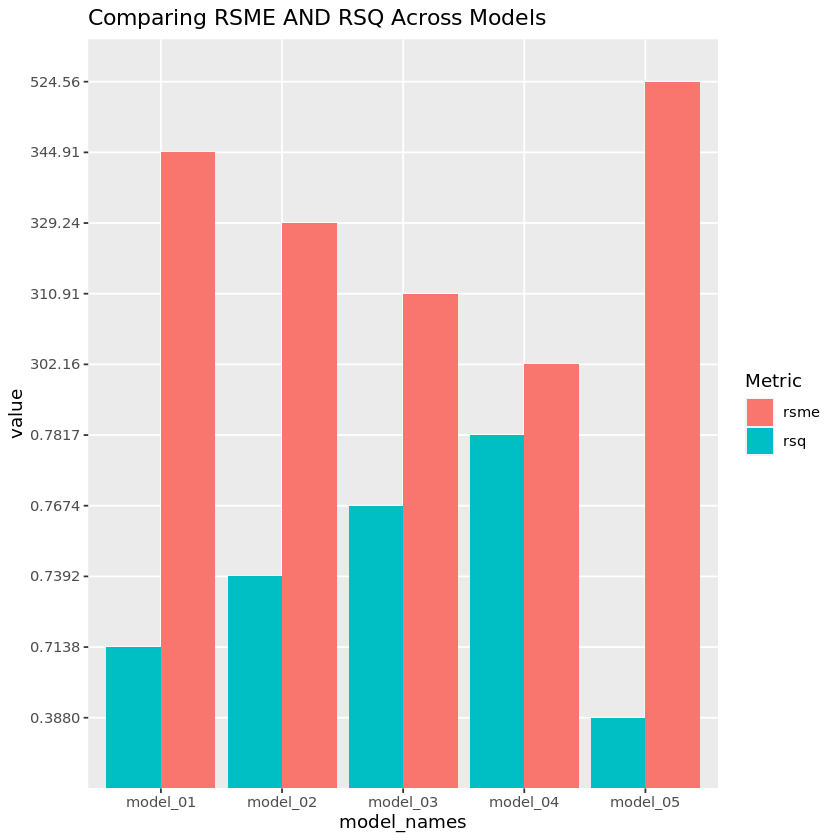

In [26]:
# HINT: Use ggplot() + geom_bar()
model_names <- c("model_01", "model_02", "model_03", "model_04", "model_05")
rsq <- c("0.7138", "0.7392", "0.7674", "0.7817", "0.3880")
rsme <- c("344.91", "329.24", "310.91", "302.16", "524.56")
comparison_df <- data.frame(model_names, rsq, rsme)

comparison_df %>%
  pivot_longer(!model_names) %>%
  ggplot(aes(x = model_names, y = value, fill = name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Comparing RSME AND RSQ Across Models", fill = "Metric")

_TODO:_ Create a Q-Q plot by plotting the distribution difference between the predictions generated by your best model and the true values on the test dataset.


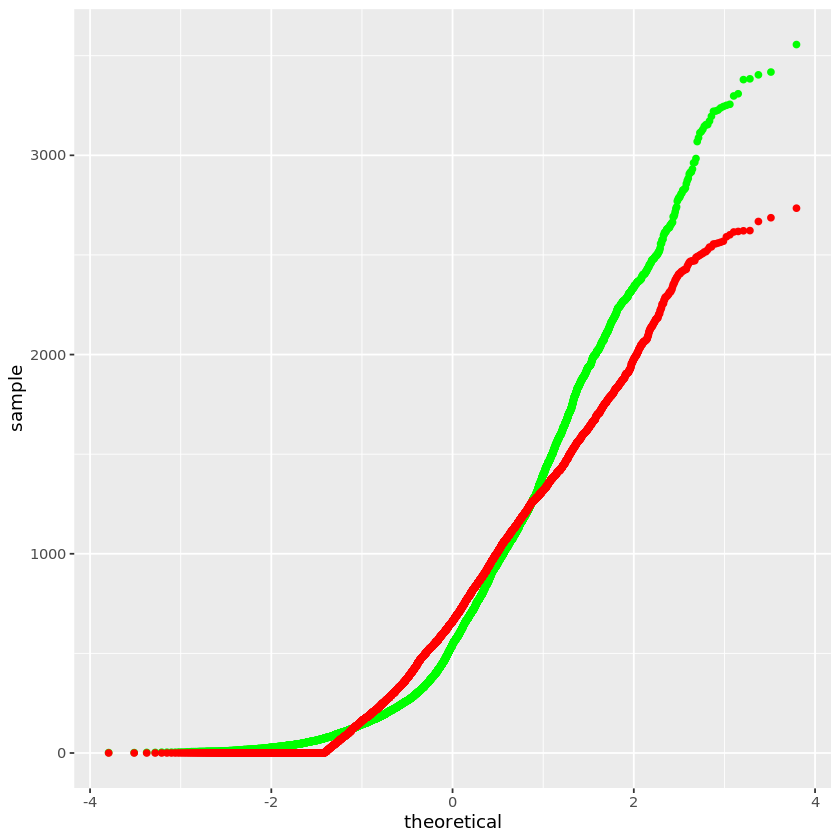

In [27]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
ggplot(model_04_results) +
  stat_qq(aes(sample = truth), color = "green") +
  stat_qq(aes(sample = .pred), color = "red")

One example of such Q-Q plot may look like this:


<a href="https://cognitiveclass.ai/">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/example_qq_plot.png" width="600" align="center">
</a>


# More model improvment methods beyond this course


In addition to the methods mentioned in this lab and previous data analysis courses, you could also explore to try the following methods yourself to see if they could improve model performance:
 - Remove potential redundant variables. If two variables have extremly high correlated, it is possible that they are redundant and could be removed from the model to improve the performance.
 - Remove some outliers. Linear regression models are very sensitive to outliers, you could try to remove some outliers to see if it would improve performance
 - Apply logarithm transformation. In case variable distributions are not normal distribution such as log-normal distribution, you could apply logaritm transformation on the variable to make them more look like normal distribution. In addition, logarithm transformation helps capture the non-linear relationships.
 
If you have time, you could research and try more methods by searching related research papers/articles, discussion forums, etc. If you know how to use other machine learning models with `Tidymodels` such as Neural Networks, Tree models, or Boosting models, you can also try and compare them with the linear regression models.


# Next Steps:


Great! You have improved your baseline model using polynomial terms, interaction terms, and regularizations, and have found your best model.

Now it's time to build an interactive dashboard to provide more interactive user-interactions.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description           |
| ----------------- | ------- | ---------- | ---------------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created      |
|                   |         |            |                              |
|                   |         |            |                              |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
